# LOBSTER

Stands for Limit Order Book System - The Efficient Reconstructor. 

It started offering limit order book data to academics way back in 2013, but has evolved into a full-fledged data source for commercial interests such as investment banks and hedge funds. It is a great source that we really should be able to work with.

It reconstructs NASDAQ's TotalView-ITCH data, so it is related to what we did in that other notebook.

You can get data at 200 different levels of "completeness", depending on your needs, starting on June 27th 2007 (2007-06-27) going through the day before yesterday. 

A single subscription gives 10 people access to the full database. 

Find out more here:
https://lobsterdata.com/

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pathlib import Path
from itertools import chain

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')

# Loading Order Book Data

In [ ]:
path = Path('data')

In [ ]:
# this part creates a list of column names for our order book DataFrame

# make column names for price DataFrame
price = list(chain(*[('Ask Price {0},Bid Price {0}'.format(i)).split(',') for i in range(10)]))
# make column names for size DataFrame
size = list(chain(*[('Ask Size {0},Bid Size {0}'.format(i)).split(',') for i in range(10)]))
# fix cols together
cols = list(chain(*zip(price, size)))
cols

['Ask Price 0',
 'Ask Size 0',
 'Bid Price 0',
 'Bid Size 0',
 'Ask Price 1',
 'Ask Size 1',
 'Bid Price 1',
 'Bid Size 1',
 'Ask Price 2',
 'Ask Size 2',
 'Bid Price 2',
 'Bid Size 2',
 'Ask Price 3',
 'Ask Size 3',
 'Bid Price 3',
 'Bid Size 3',
 'Ask Price 4',
 'Ask Size 4',
 'Bid Price 4',
 'Bid Size 4',
 'Ask Price 5',
 'Ask Size 5',
 'Bid Price 5',
 'Bid Size 5',
 'Ask Price 6',
 'Ask Size 6',
 'Bid Price 6',
 'Bid Size 6',
 'Ask Price 7',
 'Ask Size 7',
 'Bid Price 7',
 'Bid Size 7',
 'Ask Price 8',
 'Ask Size 8',
 'Bid Price 8',
 'Bid Size 8',
 'Ask Price 9',
 'Ask Size 9',
 'Bid Price 9',
 'Bid Size 9']

In [ ]:
# Need this to download the data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# stole this part from the algoseek notebook!

# used to download the data while saving ONLY the extracted file
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO

LOBSTER_path = Path('../../data/LOBSTER')

zip_url = 'https://lobsterdata.com/info/sample/LOBSTER_SampleFile_AMZN_2012-06-21_10.zip'
with urlopen(zip_url) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall(LOBSTER_path)

In [ ]:
# now we can open the file
orderbook_path = LOBSTER_path / 'AMZN_2012-06-21_34200000_57600000_orderbook_10.csv'
orderbook_data = pd.read_csv(orderbook_path, header=None, names = cols)

In [ ]:
orderbook_data.head()

,Ask Price 0,Ask Size 0,Bid Price 0,Bid Size 0,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5,Ask Price 6,Ask Size 6,Bid Price 6,Bid Size 6,Ask Price 7,Ask Size 7,Bid Price 7,Bid Size 7,Ask Price 8,Ask Size 8,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9
0,2239500,100,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100,2245400,100,2213000,4000,2248900,100,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,2239500,100,2238100,21,2239900,100,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10,2245400,100,2226200,100,2248900,100,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000,2298000,100,2202000,100
2,2239500,100,2238100,21,2239600,20,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100,2245400,100,2213000,4000,2248900,100,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100
3,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10,2245400,100,2226200,100,2248900,100,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000
4,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,2231800,100,2240000,233,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10,2245400,100,2226200,100,2248900,100,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000


The way this data works...
* **Ask Price 0** is the *best* Ask Price
* **Ask Size 0** is the order size for the *best* Ask Price
* **Bid Price 0** is the *best* Bid Price
* **Bid Size 0** is the order size for the *best* Bid Price
<p> &nbsp; </p>

* **Ask Price 1** is the *second best* Ask Price
* **Ask Size 1** is the order size for the *second best* Ask Price
* **Bid Price 1** is the *second best* Bid Price
* **Bid Size 1** is the order size for the *second best* Bid Price
<p> &nbsp; </p>

And so on...

In [ ]:
orderbook_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269748 entries, 0 to 269747
Data columns (total 40 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Ask Price 0  269748 non-null  int64
 1   Ask Size 0   269748 non-null  int64
 2   Bid Price 0  269748 non-null  int64
 3   Bid Size 0   269748 non-null  int64
 4   Ask Price 1  269748 non-null  int64
 5   Ask Size 1   269748 non-null  int64
 6   Bid Price 1  269748 non-null  int64
 7   Bid Size 1   269748 non-null  int64
 8   Ask Price 2  269748 non-null  int64
 9   Ask Size 2   269748 non-null  int64
 10  Bid Price 2  269748 non-null  int64
 11  Bid Size 2   269748 non-null  int64
 12  Ask Price 3  269748 non-null  int64
 13  Ask Size 3   269748 non-null  int64
 14  Bid Price 3  269748 non-null  int64
 15  Bid Size 3   269748 non-null  int64
 16  Ask Price 4  269748 non-null  int64
 17  Ask Size 4   269748 non-null  int64
 18  Bid Price 4  269748 non-null  int64
 19  Bid Size 4   269748 non

# Loading Message Data

Every orderbook file from LOBSTER also has a message attached. 

The message includes valuable information, such as...
<p> &nbsp; </p>

* **Time (sec)** - seconds after midnight at which event happened
* **Event Type**
  * 1: Submission of New Order
  * 2: Cancellation (partial deletion) of order
  * 3: Deletion (complete deletion) of order
  * 4: Execution of a *visible* limit order
  * 5: Execution of a *hidden* limit order
  * 6: Cross trade
  * 7: Trading Halt
* **Order ID** - Unique reference number (will be negative for cross trades)
* **Size** - Number of shares
* **Price** - Dollar price $\times$ 10,000
* **Direction**
  * -1: Sell order
  * 1: Buy Order
    * Wherein execution of Sell order indicates a *Buyer* initiated trade.
    * The Seller places a limit order, which is executed by the Buyer


In [ ]:
# a more modular way to open the message data file
# data is from 2012-06-21
date = '2012-06-21'
# it has 10 levels
levels = 10

message_path = LOBSTER_path / 'AMZN_{}_34200000_57600000_message_{}.csv'.format(date, levels)

message_data = pd.read_csv(message_path, header=None, names=['Time', 'Event Type', 'Order ID', 'Size', 'Price', 'Direction'])
message_data.head()

,Time,Event Type,Order ID,Size,Price,Direction
0,34200.017460,5,0,1,2238200,-1
1,34200.189608,1,11885113,21,2238100,1
2,34200.189608,1,3911376,20,2239600,-1
3,34200.189608,1,11534792,100,2237500,1
4,34200.189608,1,1365373,13,2240000,-1


In [ ]:
message_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269748 entries, 0 to 269747
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Time        269748 non-null  float64
 1   Event Type  269748 non-null  int64  
 2   Order ID    269748 non-null  int64  
 3   Size        269748 non-null  int64  
 4   Price       269748 non-null  int64  
 5   Direction   269748 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 12.3 MB


### How many executions were visible?

In [ ]:
event_counts = message_data['Event Type'].value_counts()
event_counts

1    131954
3    123458
4      8974
2      2917
5      2445
Name: Event Type, dtype: int64

In [ ]:
percent_visible = event_counts[4] / (event_counts[4] + event_counts[5])
print('Approximately {:.0f}% of executions were visible'.format(percent_visible*100))

Approximately 79% of executions were visible


### Change Event Types from numbers to description

In [ ]:
# dictionaty to parse Event Types
# remember that the 'Event Type' column is of type 'int64'
event_types = {1:'Submission',
               2:'Cancellation',
               3:'Deletion',
               4:'Visible_Execution',
               5:'Hidden_Execution',
               6:'Cross_Trade',
               7:'Trading_Halt'}

In [ ]:
message_data['Description of Event'] = message_data['Event Type'].map(event_types)
message_data.head()

,Time,Event Type,Order ID,Size,Price,Direction,Description of Event
0,34200.017460,5,0,1,2238200,-1,Hidden_Execution
1,34200.189608,1,11885113,21,2238100,1,Submission
2,34200.189608,1,3911376,20,2239600,-1,Submission
3,34200.189608,1,11534792,100,2237500,1,Submission
4,34200.189608,1,1365373,13,2240000,-1,Submission


### Change 'Time' column to actual time

In [ ]:
# the 'Time' column is the number of seconds after midnight at which the event occurred.
# this first line tells Python to treat it as such
message_data['Time'] = pd.to_timedelta(message_data['Time'], unit='s')

# this is an easy way to put the date and timedelta together to get the correct time
message_data['Date'] = pd.to_datetime(date)
message_data['Time'] = message_data['Date'].add(message_data['Time'])

# we don't need the 'Date' column any more
message_data.drop('Date', axis=1, inplace=True)

# let's check it out
message_data.head()

,Time,Event Type,Order ID,Size,Price,Direction,Description of Event
0,2012-06-21 09:30:00.017459617,5,0,1,2238200,-1,Hidden_Execution
1,2012-06-21 09:30:00.189607670,1,11885113,21,2238100,1,Submission
2,2012-06-21 09:30:00.189607670,1,3911376,20,2239600,-1,Submission
3,2012-06-21 09:30:00.189607670,1,11534792,100,2237500,1,Submission
4,2012-06-21 09:30:00.189607670,1,1365373,13,2240000,-1,Submission


# Combine Message and Price data!

Now let's put it all together so we can see all of what the order book has to tell us.

In [ ]:
whole_data = pd.concat([message_data, orderbook_data], axis=1)
whole_data.head()

,Time,Event Type,Order ID,Size,Price,Direction,Description of Event,Ask Price 0,Ask Size 0,Bid Price 0,Bid Size 0,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5,Ask Price 6,Ask Size 6,Bid Price 6,Bid Size 6,Ask Price 7,Ask Size 7,Bid Price 7,Bid Size 7,Ask Price 8,Ask Size 8,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9
0,2012-06-21 09:30:00.017459617,5,0,1,2238200,-1,Hidden_Execution,2239500,100,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100,2245400,100,2213000,4000,2248900,100,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,2012-06-21 09:30:00.189607670,1,11885113,21,2238100,1,Submission,2239500,100,2238100,21,2239900,100,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10,2245400,100,2226200,100,2248900,100,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000,2298000,100,2202000,100
2,2012-06-21 09:30:00.189607670,1,3911376,20,2239600,-1,Submission,2239500,100,2238100,21,2239600,20,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100,2245400,100,2213000,4000,2248900,100,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100
3,2012-06-21 09:30:00.189607670,1,11534792,100,2237500,1,Submission,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10,2245400,100,2226200,100,2248900,100,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000
4,2012-06-21 09:30:00.189607670,1,1365373,13,2240000,-1,Submission,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,2231800,100,2240000,233,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10,2245400,100,2226200,100,2248900,100,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000


Now we can see the time of the event, the event type, the order ID, size, price, a desciption of the event, as well as the 10 best Bid/Ask Prices/Sizes all at once!

In [ ]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269748 entries, 0 to 269747
Data columns (total 47 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time                  269748 non-null  datetime64[ns]
 1   Event Type            269748 non-null  int64         
 2   Order ID              269748 non-null  int64         
 3   Size                  269748 non-null  int64         
 4   Price                 269748 non-null  int64         
 5   Direction             269748 non-null  int64         
 6   Description of Event  269748 non-null  object        
 7   Ask Price 0           269748 non-null  int64         
 8   Ask Size 0            269748 non-null  int64         
 9   Bid Price 0           269748 non-null  int64         
 10  Bid Size 0            269748 non-null  int64         
 11  Ask Price 1           269748 non-null  int64         
 12  Ask Size 1            269748 non-null  int64         
 13 

# Pull out just executed trades

Maybe what we mostly care about is executed trades. Pulling those out is easy.

In [ ]:
executed = whole_data[whole_data['Event Type'].isin([4,5])]
executed['Event Type'].value_counts()

4    8974
5    2445
Name: Event Type, dtype: int64

In [ ]:
executed.head()

,Time,Event Type,Order ID,Size,Price,Direction,Description of Event,Ask Price 0,Ask Size 0,Bid Price 0,Bid Size 0,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5,Ask Price 6,Ask Size 6,Bid Price 6,Bid Size 6,Ask Price 7,Ask Size 7,Bid Price 7,Bid Size 7,Ask Price 8,Ask Size 8,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9
0,2012-06-21 09:30:00.017459617,5,0,1,2238200,-1,Hidden_Execution,2239500,100,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100,2245400,100,2213000,4000,2248900,100,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
32,2012-06-21 09:30:00.190226476,4,11885113,21,2238100,1,Visible_Execution,2239500,100,2237500,100,2239600,20,2236500,2,2239900,100,2236000,15,2240000,1451,2235000,100,2242400,20,2234900,50,2242500,100,2231800,100,2243000,500,2230700,200,2244000,547,2230400,100,2244900,100,2230000,10,2245000,5,2226200,100
33,2012-06-21 09:30:00.190226476,4,11534792,26,2237500,1,Visible_Execution,2239500,100,2237500,74,2239600,20,2236500,2,2239900,100,2236000,15,2240000,1451,2235000,100,2242400,20,2234900,50,2242500,100,2231800,100,2243000,500,2230700,200,2244000,547,2230400,100,2244900,100,2230000,10,2245000,5,2226200,100
37,2012-06-21 09:30:00.372779672,5,0,100,2238400,-1,Hidden_Execution,2239500,100,2237500,74,2239600,20,2236500,2,2239900,100,2236000,15,2240000,1451,2235000,100,2242400,20,2234900,50,2242500,100,2230700,200,2243000,500,2230000,10,2244000,447,2226200,100,2244900,100,2213000,4000,2245000,5,2204000,100
38,2012-06-21 09:30:00.375671205,5,0,100,2238400,-1,Hidden_Execution,2239500,100,2237500,74,2239600,20,2236500,2,2239900,100,2236000,15,2240000,1451,2235000,100,2242400,20,2234900,50,2242500,100,2230700,200,2243000,500,2230000,10,2244000,447,2226200,100,2244900,100,2213000,4000,2245000,5,2204000,100


In [ ]:
executed.tail()

,Time,Event Type,Order ID,Size,Price,Direction,Description of Event,Ask Price 0,Ask Size 0,Bid Price 0,Bid Size 0,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5,Ask Price 6,Ask Size 6,Bid Price 6,Bid Size 6,Ask Price 7,Ask Size 7,Bid Price 7,Bid Size 7,Ask Price 8,Ask Size 8,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9
269719,2012-06-21 15:59:59.241762108,4,286932759,100,2205200,1,Visible_Execution,2206400,160,2205100,400,2206500,1265,2205000,71,2206600,100,2204800,700,2206900,170,2204700,200,2207100,1800,2204600,1704,2207400,800,2204500,200,2207500,200,2204400,800,2207600,100,2204200,100,2207900,2300,2204100,3200,2208000,3100,2204000,300
269722,2012-06-21 15:59:59.242004091,4,287140745,9,2205300,-1,Visible_Execution,2205300,91,2205100,400,2206100,100,2205000,71,2206400,160,2204800,700,2206500,1265,2204700,200,2206600,100,2204600,1704,2206900,170,2204500,200,2207100,1800,2204400,800,2207400,800,2204200,100,2207500,200,2204100,3200,2207600,100,2204000,300
269730,2012-06-21 15:59:59.402706727,4,282917222,91,2205100,1,Visible_Execution,2206100,100,2205100,309,2206200,100,2205000,71,2206400,160,2204800,600,2206500,1290,2204700,200,2206900,170,2204600,1704,2207100,1800,2204500,200,2207400,800,2204400,800,2207500,200,2204300,100,2207600,200,2204200,100,2207900,2300,2204100,3200
269739,2012-06-21 15:59:59.545827862,4,282917222,9,2205100,1,Visible_Execution,2206200,100,2205100,300,2206400,100,2205000,71,2206500,1290,2204800,700,2206700,170,2204700,100,2206900,170,2204600,1704,2207100,1800,2204500,200,2207400,800,2204400,800,2207500,200,2204300,2300,2207600,200,2204200,100,2207900,2300,2204100,3200
269740,2012-06-21 15:59:59.545827862,4,286916542,51,2205100,1,Visible_Execution,2206200,100,2205100,249,2206400,100,2205000,71,2206500,1290,2204800,700,2206700,170,2204700,100,2206900,170,2204600,1704,2207100,1800,2204500,200,2207400,800,2204400,800,2207500,200,2204300,2300,2207600,200,2204200,100,2207900,2300,2204100,3200


In [ ]:
executed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11419 entries, 0 to 269740
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time                  11419 non-null  datetime64[ns]
 1   Event Type            11419 non-null  int64         
 2   Order ID              11419 non-null  int64         
 3   Size                  11419 non-null  int64         
 4   Price                 11419 non-null  int64         
 5   Direction             11419 non-null  int64         
 6   Description of Event  11419 non-null  object        
 7   Ask Price 0           11419 non-null  int64         
 8   Ask Size 0            11419 non-null  int64         
 9   Bid Price 0           11419 non-null  int64         
 10  Bid Size 0            11419 non-null  int64         
 11  Ask Price 1           11419 non-null  int64         
 12  Ask Size 1            11419 non-null  int64         
 13  Bid Price 1    

# Make plots of bid/ask spread?

In [ ]:
# color coding
color_map = {'Bid':'Blues', 'Ask':'Reds'}

In [ ]:
from datetime import datetime

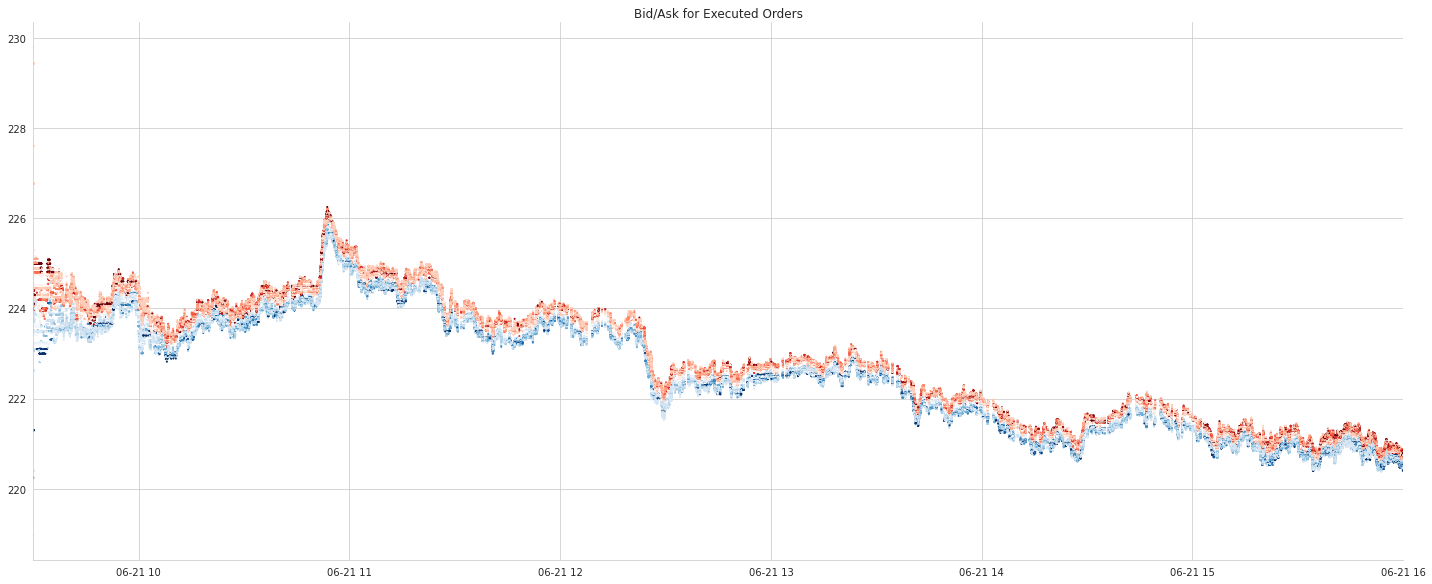

In [ ]:
# make plot
fig, ax = plt.subplots(figsize=(20,8))
# variable for x-axis, keeping only the Time not the Date
time = executed['Time']

# loop through all 10 best Ask/Bid Prices/Sizes
for i in range(10):
  # loop through Bids and Asks
  for j in ['Bid', 'Ask']:
    # get Price and Size
    y = executed['{} Price {}'.format(j, i)] / 10000
    c = executed['{} Size {}'.format(j, i)]
    # put points on scatterplot
    ax.scatter(x=time, y=y, c=c, cmap=color_map[j], s=1, vmin=1, vmax=c.quantile(0.95))
# all executions occur after '2012-06-21 09:30:00' and before '2012-06-21 16:00:00'
ax.set_xlim(datetime(2012,6,21,9,30), datetime(2012,6,21,16,0))
# make it look pretty
sns.despine()
fig.tight_layout();
plt.title('Bid/Ask for Executed Orders');

# Plotting All the Bid/Ask Prices

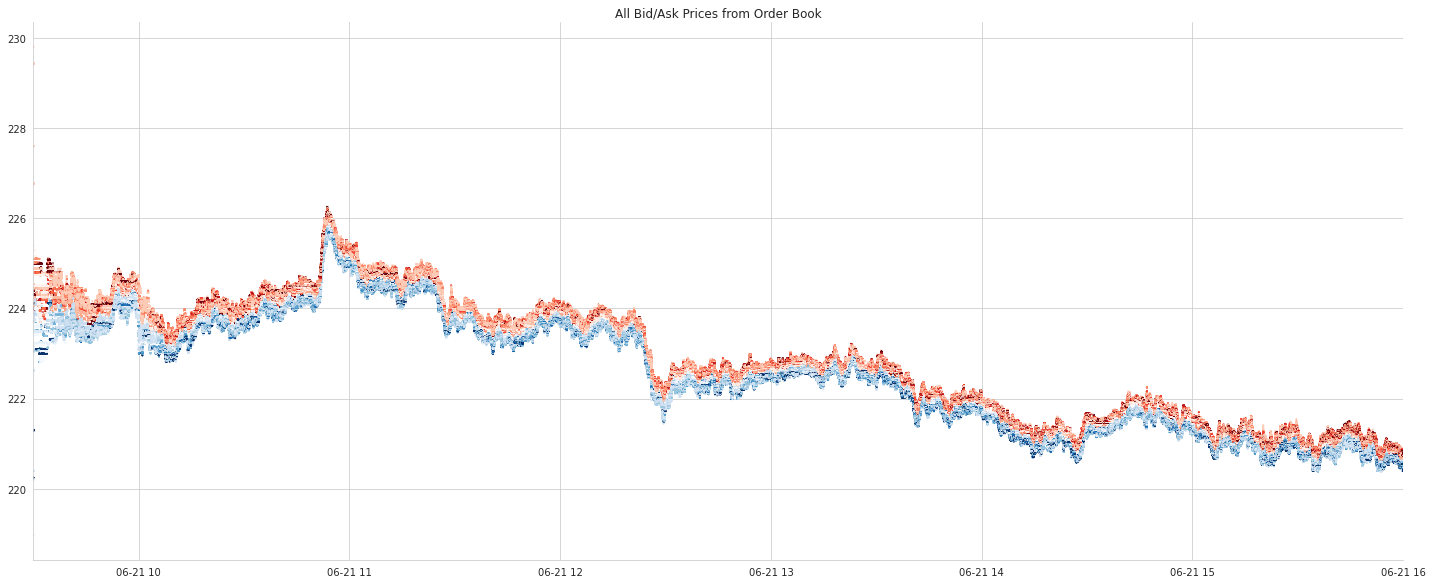

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

# get the time values for the x-axis
time = whole_data['Time']

# loop over all 10 Bid/Ask Prices/Sizes
for i in range(10):
  # loop over Bid/Ask
  for j in ['Bid', 'Ask']:
    # get price and size
    y = whole_data['{} Price {}'.format(j,i)] / 10000
    c = whole_data['{} Size {}'.format(j,i)]

    # add points to scatterplot
    ax.scatter(x=time, y=y, c=c, cmap=color_map[j], s=1, vmin=1, vmax=c.quantile(0.95))
# Everything occurs between '2012-06-21 09:30:00' and '2016-06-21 16:00:00'
ax.set_xlim(datetime(2012,6,21,9,30), datetime(2012,6,21,16,0))

# make it look pretty
sns.despine()
fig.tight_layout()
plt.title('All Bid/Ask Prices from Order Book');